<a href="https://colab.research.google.com/github/Keetawin/DenseNetChestXrayClassification/blob/main/DenseNet121_ChestXray_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import required Library

In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from torchinfo import summary
import data_setup, engine, utils

In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Import Dataset

In [ ]:
!pip install opendatasets


In [ ]:
import opendatasets as od

In [ ]:
od.download("https://www.kaggle.com/datasets/alsaniipe/chest-x-ray-image")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: keetawin
Your Kaggle Key: ··········


100%|██████████| 2.06G/2.06G [01:13<00:00, 29.9MB/s]


# Setup Path

In [ ]:
import os
from pathlib import Path

# Setup path to data folder
data_path = Path("chest-x-ray-image/")
image_path = data_path / "Data"

In [ ]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

# Plot Distribution

In [ ]:
import seaborn as sns

def plot_class_distribution(train_dir):
    # Get a list of class names (assuming each class has its folder)
    class_names = os.listdir(train_dir)

    # Initialize an empty dictionary to store counts for each class
    class_counts = {}

    # Iterate through class folders and count the number of images
    for class_name in class_names:
        class_path = os.path.join(train_dir, class_name)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            class_counts[class_name] = num_images

    # Convert the dictionary to lists for plotting
    labels, counts = zip(*class_counts.items())

    # Create a count plot
    sns.barplot(x=list(labels), y=list(counts))  # Convert to lists

    # Set plot labels and title
    plt.xlabel('Class Labels')
    plt.ylabel('Count')
    plt.title('Number of Images in Each Class in Train Dataset')

    # Rotate x-axis labels for better visibility
    plt.xticks(rotation=45, ha="right")

    # Show the plot
    plt.show()

    # Return the class counts dictionary
    return class_counts

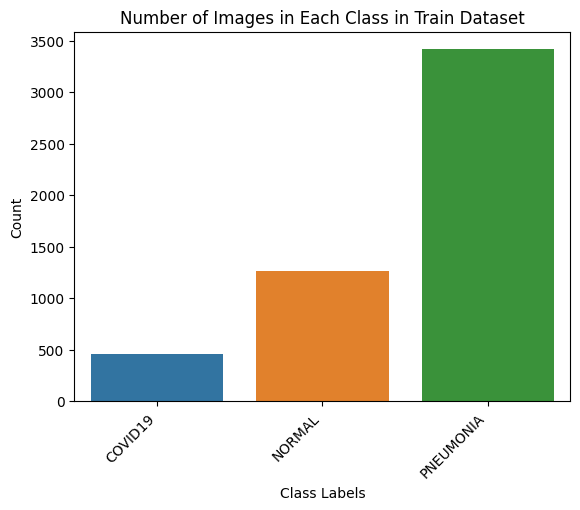

In [ ]:
class_counts = plot_class_distribution(train_dir)

# Data Augmentation

In [ ]:
target_count = class_counts['PNEUMONIA']

In [ ]:
from torchvision import transforms
from PIL import Image
import random

def augment_class(class_path, target_count):
    num_images = len(os.listdir(class_path))
    if num_images < target_count:
        transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(degrees=30),
            transforms.RandomAffine(degrees=0, translate=(0.15, 0.15)),
        ])

        for i in range(target_count - num_images):
            image_path = os.path.join(class_path, random.choice(os.listdir(class_path)))
            image = Image.open(image_path)
            image_aug = transform(image)
            image_aug = image_aug.convert("RGB")  # แปลงภาพเป็นโหมด RGB
            image_aug.save(os.path.join(class_path, f"aug_{i}_{os.path.basename(image_path)}"))


In [ ]:
for class_name in ['COVID19', 'NORMAL']:
    class_path = os.path.join(train_dir, class_name)
    augment_class(class_path, target_count)


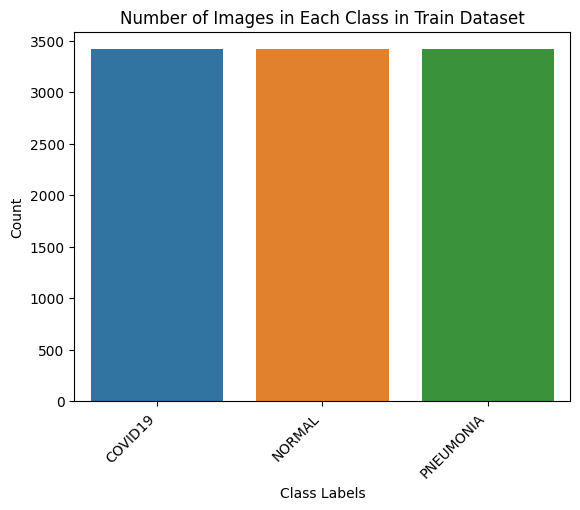

In [ ]:
class_counts = plot_class_distribution(train_dir)

# Create DenseNet121 Model

In [2]:
weights = torchvision.models.DenseNet121_Weights.DEFAULT

In [ ]:
model = torchvision.models.densenet121(weights=weights).to(device)

In [ ]:
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1024,
                    out_features=3, # same number of output units as our number of classes
                    bias=True)).to(device)

# Preprocessing & Train Test split

In [3]:
auto_transforms = weights.transforms()

In [4]:
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7aa68083ec50>,
 ['COVID19', 'NORMAL', 'PNEUMONIA'])

In [ ]:
# Assuming you already have train_dataloader from the previous code
train_dataloader, validation_dataloader = data_setup.split_train_validation(train_dataloader)

# Check the lengths of the new dataloaders
len(train_dataloader.dataset), len(validation_dataloader.dataset), len(test_dataloader.dataset)

(9229, 1025, 1288)

# Train Model

In [ ]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=validation_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1662 | train_acc: 0.9418 | test_loss: 0.7049 | test_acc: 0.8059
Epoch: 2 | train_loss: 0.1052 | train_acc: 0.9639 | test_loss: 0.1335 | test_acc: 0.9366
Epoch: 3 | train_loss: 0.0840 | train_acc: 0.9696 | test_loss: 0.2994 | test_acc: 0.8968
Epoch: 4 | train_loss: 0.0722 | train_acc: 0.9739 | test_loss: 0.1774 | test_acc: 0.9479
Epoch: 5 | train_loss: 0.0688 | train_acc: 0.9766 | test_loss: 0.0955 | test_acc: 0.9735
[INFO] Total training time: 309.923 seconds


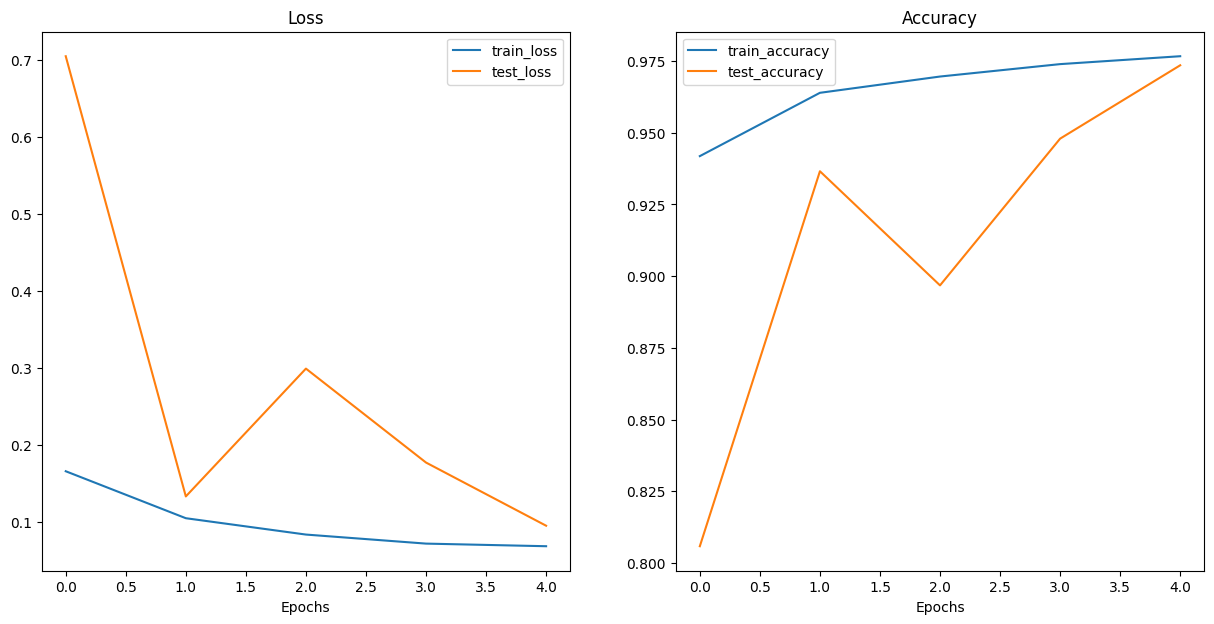

In [ ]:
import requests
request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
f.write(request.content)
from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

# Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

def test_model(model, test_dataloader):
    model.eval()
    true_labels = []
    predicted_labels = []
    with torch.no_grad():
        for images, labels in test_dataloader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            true_labels.extend(labels.tolist())
            predicted_labels.extend(predicted.tolist())

    # คำนวณ accuracy โดยใช้ sklearn.metrics.accuracy_score
    accuracy = accuracy_score(true_labels, predicted_labels)

    precision = precision_score(true_labels, predicted_labels, average='macro')
    recall = recall_score(true_labels, predicted_labels, average='macro')
    f1 = f1_score(true_labels, predicted_labels, average='macro')
    cm = confusion_matrix(true_labels, predicted_labels)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Confusion Matrix")

    cm = confusion_matrix(true_labels, predicted_labels)

    # แสดง confusion matrix ด้วย seaborn
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()



Accuracy: 0.9572981366459627
Precision: 0.9622326953796044
Recall: 0.9505949098061518
F1 Score: 0.9562752231603012
Confusion Matrix


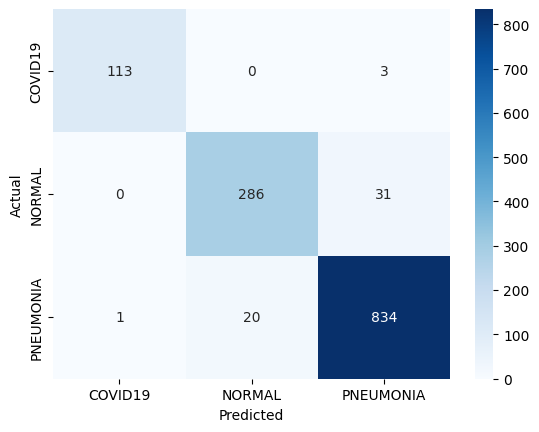

In [ ]:
test_model(model, test_dataloader)

# Save Model

In [ ]:
# Save the model
utils.save_model(model=model,
                 target_dir="models",
                 model_name="densenet_chest_xray_weight.pth")

[INFO] Saving model to: models/densenet_chest_xray_weight.pth


# Gradio Deployment

In [ ]:
import shutil
from pathlib import Path

# Create Chest X ray demo path
chest_xray_demo_path = Path("demos/chest_xray/")

# Remove files that might already exist there and create new directory
if chest_xray_demo_path.exists():
    shutil.rmtree(chest_xray_demo_path)
    chest_xray_demo_path.mkdir(parents=True, # make the parent folders?
                                    exist_ok=True) # create it even if it already exists?
else:
    # If the file doesn't exist, create it anyway
    chest_xray_demo_path.mkdir(parents=True,
                                    exist_ok=True)

# Check what's in the folder
!ls demos/chest_xray/

In [ ]:
import shutil
from pathlib import Path

# 1. Create an examples directory
chest_xray_examples_path = chest_xray_demo_path / "examples"
chest_xray_examples_path.mkdir(parents=True, exist_ok=True)

# 2. Collect three random test dataset image paths
chest_xray_examples = [Path('chest-x-ray-image/Data/test/COVID19/COVID19(551).jpg'),
                            Path('chest-x-ray-image/Data/test/NORMAL/NORMAL(1283).jpg'),
                            Path('chest-x-ray-image/Data/test/PNEUMONIA/PNEUMONIA(4112).jpg')]

# 3. Copy the three random images to the examples directory
for example in chest_xray_examples:
    destination = chest_xray_examples_path / example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src=example, dst=destination)

[INFO] Copying chest-x-ray-image/Data/test/COVID19/COVID19(551).jpg to demos/chest_xray/examples/COVID19(551).jpg
[INFO] Copying chest-x-ray-image/Data/test/NORMAL/NORMAL(1283).jpg to demos/chest_xray/examples/NORMAL(1283).jpg
[INFO] Copying chest-x-ray-image/Data/test/PNEUMONIA/PNEUMONIA(4112).jpg to demos/chest_xray/examples/PNEUMONIA(4112).jpg


In [ ]:
import shutil

# Create a source path for our target model
densenet_chest_xray_model_path = "models/densenet_chest_xray_weight.pth"

# Create a destination path for our target model
densenet_chest_xray_model_model_destination = chest_xray_demo_path / densenet_chest_xray_model_path.split("/")[1]

# Try to move the file
try:
    print(f"[INFO] Attempting to move {densenet_chest_xray_model_path} to {densenet_chest_xray_model_model_destination}")

    # Move the model
    shutil.move(src=densenet_chest_xray_model_path,
                dst=densenet_chest_xray_model_model_destination)

    print(f"[INFO] Model move complete.")

# If the model has already been moved, check if it exists
except:
    print(f"[INFO] No model found at {densenet_chest_xray_model_path}, perhaps its already been moved?")
    print(f"[INFO] Model exists at {densenet_chest_xray_model_model_destination}: {densenet_chest_xray_model_model_destination.exists()}")

[INFO] Attempting to move models/densenet_chest_xray_weight.pth to demos/chest_xray/densenet_chest_xray_weight.pth
[INFO] Model move complete.


In [ ]:
%%writefile demos/chest_xray/model.py
import torch
import torchvision

from torch import nn


def create_densenet121_model(num_classes:int=3,
                          seed:int=42):
    # Create DenseNet121 pretrained weights, transforms and model
    weights = torchvision.models.DenseNet121_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.densenet121(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)

    model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1024,
                    out_features=3,
                    bias=True))

    return model, transforms

Writing demos/chest_xray/model.py


In [ ]:
%%writefile demos/chest_xray/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_densenet121_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ["COVID19", "NORMAL", "PNEUMONIA"]

### 2. Model and transforms preparation ###

# Create DenseNet121 model
densenet121, densenet121_transforms = create_densenet121_model(
    num_classes=3, # len(class_names) would also work
)

# Load saved weights
densenet121.load_state_dict(
    torch.load(
        f="densenet_chest_xray_weight.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = densenet121_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    densenet121.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(densenet121(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "Chest X-ray Analysis for COVID-19, Pneumonia, and Normal Cases using DenseNet121"
description = "Utilizing Deep Learning for accurate detection and classification of Chest X-ray images."
article = "This project employs the DenseNet121 model to analyze Chest X-ray images for classification into COVID-19, Pneumonia, and Normal cases. Leveraging the capabilities of Deep Learning, the model ensures precise and reliable results, contributing to improved medical diagnostics."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    # Create examples list from "examples/" directory
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch()

Writing demos/chest_xray/app.py


In [ ]:
%%writefile demos/chest_xray/requirements.txt
torch==1.12.0
torchvision==0.13.0
gradio==3.1.4

Writing demos/chest_xray/requirements.txt


In [ ]:
!ls demos/chest_xray

app.py	densenet_chest_xray_weight.pth	examples  model.py  requirements.txt


In [ ]:
# Change into and then zip the foodvision_mini folder but exclude certain files
!cd demos/chest_xray && zip -r ../chest_xray.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# Download the zipped FoodVision Mini app (if running in Google Colab)
try:
    from google.colab import files
    files.download("demos/chest_xray.zip")
except:
    print("Not running in Google Colab, can't use google.colab.files.download(), please manually download.")

  adding: app.py (deflated 58%)
  adding: densenet_chest_xray_weight.pth (deflated 7%)
  adding: examples/ (stored 0%)
  adding: examples/NORMAL(1283).jpg (deflated 0%)
  adding: examples/PNEUMONIA(4112).jpg (deflated 7%)
  adding: examples/COVID19(551).jpg (deflated 3%)
  adding: model.py (deflated 52%)
  adding: requirements.txt (deflated 4%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>